## To Do
- Prevent/improve handling of duplicates

In [54]:
from pathlib import Path
import gc

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupShuffleSplit, GroupKFold #train_test_split, RepeatedKFold
from sklearn.linear_model import Ridge #, RidgeCV
#from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from custom.preprocessing import (
    preserve_geometry,
    _add_shrug_to_mosaiks,
    _merge_mosaiks_and_secc,
)
from custom.shrug_data import (
    load_shrug_shapefiles,
    load_shrug_secc,
    change_shapefile_IDs_to_int,
)
from custom.evaluation import show_results, plot_prediction_maps, plot_precision_recall_curve
from custom.utils import load_gdf, latlon_df_to_gdf

In [2]:
ROOT = Path.cwd().parent
DATA_ROOT = ROOT / "data"

## Load and merge data

### Mosaiks features (with Lat-Lon Coords)

2013 data

In [3]:
filename = '2013_exact_2400m_v4000_L8_0_to_96166.parquet.gzip'
data_label = "2013_2400m_v4000"

# Load data
mosaiks_features = pd.read_parquet(DATA_ROOT / "01_preprocessed/mosaiks_features" / filename)
mosaiks_features_gdf = latlon_df_to_gdf(mosaiks_features)
print("No. points:", mosaiks_features_gdf.shape[0])

mosaiks_features_gdf = mosaiks_features_gdf.dropna()
print("No. points after dropping NAs:", mosaiks_features_gdf.shape[0])

No. points: 96167
No. points after dropping NAs: 89677


In [4]:
# INVESTIGATE THIS! For some reason there are 2 duplicate rows in this loaded data.
# RESOLVED: This is due to .sjoin in the mosaiks_points.py script - fixed. New coordinates must be generated and requested.
filter = mosaiks_features_gdf.duplicated(subset=["Lat","Lon"], keep="first")
mosaiks_features_gdf = mosaiks_features_gdf[~filter]

2021 data

In [5]:
# data_label_21 = "2021_2400km_v4000"
filename_21 = '2021_exact_2400m_v4000_L8_0_to_96166.parquet.gzip'

# Load data
mosaiks_features_21 = pd.read_parquet(DATA_ROOT / "01_preprocessed/mosaiks_features" / filename_21)
mosaiks_features_gdf_21 = latlon_df_to_gdf(mosaiks_features_21)
print("No. points:", mosaiks_features_gdf_21.shape[0])

mosaiks_features_gdf_21 = mosaiks_features_gdf_21.dropna()
print("No. points after dropping NAs:", mosaiks_features_gdf_21.shape[0])

No. points: 96167
No. points after dropping NAs: 88688


In [6]:
# TEMPORARY FIX for duplicate rows
filter = mosaiks_features_gdf_21.duplicated(subset=["Lat","Lon"], keep="first")
mosaiks_features_gdf_21 = mosaiks_features_gdf_21[~filter]

### SHRUG data (geometries + populations + SECC)

Get shrug keys (pre-merged with shapes)

In [8]:
shrug = load_gdf(
    "01_preprocessed/SHRUG/shrug_all_keys_with_shapes",
    "shrug_all_keys_with_shapes.shp",
)
shrug = preserve_geometry(shrug, suffix="village_town")

In [9]:
### DUPLICATES ISSUE ###
# There are 9,885 duplicate rows in the SHRUG data (out of 642,938)... Drop them for now.
shrug.drop_duplicates(subset=["shrid"], inplace=True)

Add population data from the main SHRUG dataset

In [13]:
shrug_pc11 = pd.read_csv(DATA_ROOT / "00_raw/SHRUG/shrug-v1.5.samosa-pop-econ-census-csv/shrug_pc11.csv")
shrug_pop = pd.merge(
    shrug, 
    shrug_pc11[
        [
            "shrid", 
            "pc11_pca_tot_p",
            "pc11_pca_tot_p_r",
            "pc11_pca_tot_p_u",
        ]
    ],
    on="shrid",
    how="inner",
)

Add rural and urban poverty from SECC data

In [14]:
shrug_secc = load_shrug_secc()
shrug_pop_secc = pd.merge(
    shrug_pop, 
    shrug_secc[["shrid", "secc_pov_rate_rural", "secc_pov_rate_urban"]], 
    on="shrid", 
    how="inner"
)

In [15]:
# get number of SHRIDs that both have an urban rate and a rural rate for poverty
shrug_pop_secc.query("secc_pov_rate_urban > 0 and secc_pov_rate_rural > 0").shape[0]

125

In [16]:
# get combined rate of poverty using the urban and rural rates and their population as weights
shrug_pop_secc["secc_pov_rate_combined"] = (
    shrug_pop_secc["secc_pov_rate_urban"].fillna(0) * shrug_pop_secc["pc11_pca_tot_p_u"].fillna(0)
    + shrug_pop_secc["secc_pov_rate_rural"].fillna(0) * shrug_pop_secc["pc11_pca_tot_p_r"].fillna(0)
) / shrug_pop_secc["pc11_pca_tot_p"]

# reset combined value to NaN if both urban and rural rates are NaN
shrug_pop_secc.loc[
    shrug_pop_secc["secc_pov_rate_urban"].isna() & shrug_pop_secc["secc_pov_rate_rural"].isna(),
    "secc_pov_rate_combined",
] = np.nan

In [17]:
shrug_pop_secc["secc_pov_rate_combined"].describe()

count    563409.000000
mean          0.353668
std           0.221284
min           0.000000
25%           0.173968
50%           0.340506
75%           0.506821
max           1.000000
Name: secc_pov_rate_combined, dtype: float64

#### SHRUG Blocks (Group SHRUG Villages/Towns)

Take weighted average of village/town poverty rates by population within subdistricts:

In [18]:
shrug_pop_secc["pov_pop"] = shrug_pop_secc["secc_pov_rate_combined"] * shrug_pop_secc["pc11_pca_tot_p"]
shrug_block_pop_secc = shrug_pop_secc.groupby(['pc11_s_id', 'pc11_d_id', 'pc11_sd_id',]).agg(
    n_shrids=("shrid", "count"), 
    pop_sum=("pc11_pca_tot_p", "sum"),
    pov_pop_sum=("pov_pop", "sum")
).reset_index()
shrug_block_pop_secc["secc_pov_rate_subdistrict"] = shrug_block_pop_secc["pov_pop_sum"]/shrug_block_pop_secc["pop_sum"]

shrug_pop_secc.drop(columns=["pov_pop"], inplace=True)
shrug_block_pop_secc.drop(columns=["pov_pop_sum"], inplace=True)

Load and add subdistrict shapes

In [19]:
shrug_sd_shapes = load_gdf(
    "00_raw/SHRUG/geometries_shrug-v1.5.samosa-open-polygons-shp",
    "subdistrict.shp",
)
shrug_sd_shapes = change_shapefile_IDs_to_int(shrug_sd_shapes)

shrug_block_pop_secc = pd.merge(
    shrug_block_pop_secc,
    shrug_sd_shapes,
    on=["pc11_s_id", "pc11_d_id", "pc11_sd_id"],
    how="inner",
)
shrug_block_pop_secc = preserve_geometry(shrug_block_pop_secc, suffix="subdistrict")
shrug_block_pop_secc = gpd.GeoDataFrame(shrug_block_pop_secc)

In [20]:
shrug_block_pop_secc.head()

,pc11_s_id,pc11_d_id,pc11_sd_id,n_shrids,pop_sum,secc_pov_rate_subdistrict,sd_name,geometry,geometry_subdistrict
0,1,1,1,119,520591.0,0.456088,Kupwara,"POLYGON ((74.50665 34.51685, 74.50441 34.51444...","POLYGON ((74.50665 34.51685, 74.50441 34.51444..."
1,1,1,2,188,261280.0,0.348449,Handwara,"POLYGON ((74.20004 34.51438, 74.20023 34.51437...","POLYGON ((74.20004 34.51438, 74.20023 34.51437..."
2,1,1,3,41,60129.0,0.249247,Karnah,"POLYGON ((73.90129 34.44379, 73.90364 34.44372...","POLYGON ((73.90129 34.44379, 73.90364 34.44372..."
3,1,2,4,48,64972.0,0.387685,Khag,"POLYGON ((74.52723 34.04333, 74.52686 34.04173...","POLYGON ((74.52723 34.04333, 74.52686 34.04173..."
4,1,2,5,104,177222.0,0.524766,Beerwah,"POLYGON ((74.66784 34.11153, 74.66878 34.11123...","POLYGON ((74.66784 34.11153, 74.66878 34.11123..."


### Merge Mosaiks featues and SECC target via shapes

Village/town-level

In [21]:
mosaiks_shrug_vt_gdf = _add_shrug_to_mosaiks(mosaiks_features_gdf, shrug_pop_secc)

Block-level

In [22]:
mosaiks_shrug_block_gdf = _add_shrug_to_mosaiks(mosaiks_features_gdf, shrug_block_pop_secc)

In [23]:
### del relevant vars
# del shrug_secc
# del shrug_pc11
# del mosaiks_features
# del mosaiks_features_gdf
# gc.collect()

## Select data for modelling

Choose data to use for modelling

In [59]:
# Select dataset and target
gdf = mosaiks_shrug_vt_gdf  #mosaiks_shrug_block_gdf
y_name = "secc_pov_rate_combined" #"secc_pov_rate_subdistrict_combined"
experiment_name = data_label + "_" + y_name

In [29]:
# drop rows with unavailable target
gdf_clean = gdf.dropna(subset=y_name)
# drop rows with duplicated indices
filter = gdf_clean.index.duplicated(keep='first')
print("Rows with duplicated indices:", filter.sum())
gdf_clean = gdf_clean[~filter]

Rows with duplicated indices: 1


In [30]:
# select features and target
NUM_FEATURES = 4000
mosaiks_column_names = [str(i) for i in range(NUM_FEATURES)]

X = gdf_clean[mosaiks_column_names]
y = gdf_clean[y_name]

Grouped train-test split: making sure that datapoints from the same village don't get split across train and test datasets (to avoid leakage).

Can change grouping variable to larger scale if needed (e.g. unique subdistrict IDs, etc)

In [31]:
# choose train/test indices
grouping_var = "pc11_tv_id" #"pc11_sd_id"
splitter = GroupShuffleSplit(test_size=0.30, n_splits=1, random_state=0)
split = splitter.split(gdf_clean, groups=gdf_clean[grouping_var])
train_index_position, test_index_position = list(split)[0]

# convert to true pandas indices
train_index = gdf_clean.index[train_index_position]
test_index = gdf_clean.index[test_index_position]

In [32]:
# only keep test indices that also appear in the 2021 data (for comparison later)
test_index_common = np.intersect1d(test_index, mosaiks_features_gdf_21.index)
print("No. test points 2013:", len(test_index))
print("Common test points:", len(test_index_common))

No. test points 2013: 24571
Common test points: 23382


In [33]:
# split data into train and test
X_train, X_test, y_train, y_test = (
    X.loc[train_index],
    X.loc[test_index_common],
    y.loc[train_index],
    y.loc[test_index_common],
)
# select 2021 test data
X_test_21 = mosaiks_features_gdf_21.loc[test_index_common].drop(["Lat", "Lon", "geometry"], axis=1)

## Modelling
Datapoints = latlong points

### Train model

In [34]:
model = Ridge()
model.fit(X_train, y_train) #, sample_weight=y_train

Ridge()

- target distribution
- optimise model

In [35]:
# # or with parameter search (grouped k-fold)

# group_kfold = GroupKFold(n_splits=5)
# cv_grouped = group_kfold.split(X, y, gdf_clean[grouping_var])

# model = RidgeCV(alphas=[0.01, 1, 10], cv=cv_grouped)
# model.fit(X_train, y_train, sample_weight=y_train)

# # summarize chosen configuration
# print('alpha: %f' % model.alpha_)

### Test

Next, we use the trained model to make predictions in the test set.

In [36]:
y_pred = model.predict(X_test)

In [37]:
y_pred_21 = model.predict(X_test_21)

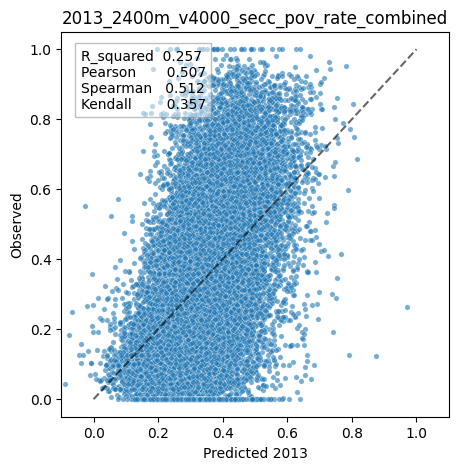

In [38]:
show_results(y_test, y_pred, file_name="scatter_"+experiment_name, title=experiment_name)

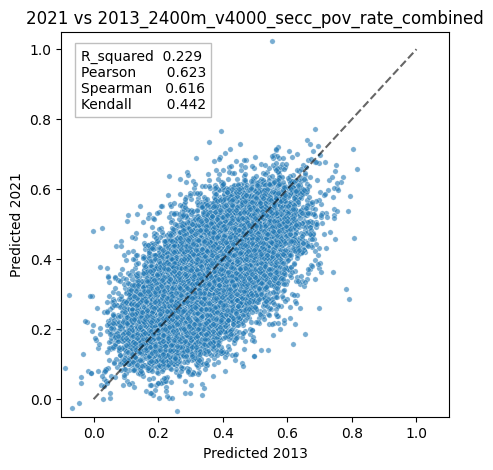

In [39]:
show_results(y_pred_21, y_pred, ylabel="Predicted 2021", file_name="2021_vs_13_scatter_"+experiment_name, title="2021 vs "+experiment_name)

In [40]:
# min, max = 0.1, 0.6
# y_pred_scaled = ((y_pred - min) / (max - min))
# y_pred_21_scaled = ((y_pred_21 - min) / (max - min))
# show_results(y_test, y_pred_scaled, file_name="scatter_scaled_"+experiment_name, line=False, title=experiment_name+" (Scaled)")

Maps

In [41]:
geo_cols = [
    "Lat", "Lon",
    "shrid",
    "pc11_s_id",
    "pc11_d_id",
    "pc11_sd_id",
    "pc11_tv_id",
    "tv_name",
    "geometry",
    "geometry_village_town"
    # "geometry_subdistrict",
]

In [42]:
# select dataframe with only test target and location data
gdf_clean_test_y = gdf_clean.loc[test_index_common][geo_cols + [y_name]]

# add predicted values
gdf_clean_test_y.loc[:, "predicted"] = y_pred
# gdf_clean_test_y.loc[:, "predicted_scaled"] = y_pred_scaled
gdf_clean_test_y.loc[:, "predicted_21"] = y_pred_21


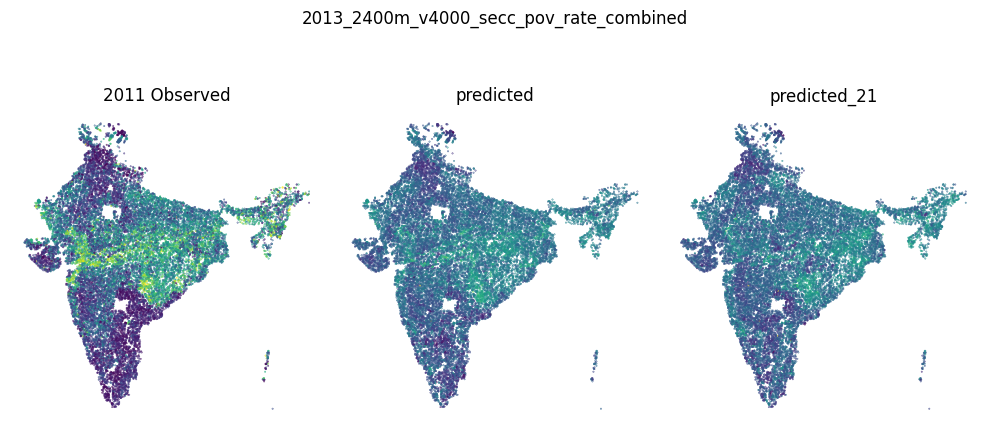

In [43]:
plot_prediction_maps(
    gdf=gdf_clean_test_y,
    y_name=y_name,
    y_pred_name="predicted",
    y_pred_2_name="predicted_21",
    vmin=0,
    vmax=1,
    file_name="2021_vs_13_maps_points_"+experiment_name,
    title=experiment_name,
    )

### Aggregate to `Subdistricts`

In [44]:
print("Total test datapoints: ", gdf_clean_test_y.shape[0])

Total test datapoints:  23382


In [45]:
sd_shapes = load_shrug_shapefiles(level="subdistrict")
sd_shapes.drop(['pc11_s_id', 'pc11_d_id', 'pc11_sd_id'], axis=1, inplace=True)
sd_shapes["geometry_subdistrict"] = sd_shapes["geometry"]

In [46]:
gdf_clean_test_y_subdistricts = gdf_clean_test_y.sjoin(sd_shapes)

# change default geometry to subdistricts (for plotting)
gdf_clean_test_y_subdistricts["geometry_point"] = gdf_clean_test_y_subdistricts["geometry"]
gdf_clean_test_y_subdistricts["geometry"] = gdf_clean_test_y_subdistricts["geometry_subdistrict"]

In [47]:
subdistrict_ys = gdf_clean_test_y_subdistricts.groupby(
    ["pc11_s_id", "pc11_d_id", "pc11_sd_id"], as_index=False,
)[[y_name, "predicted", "predicted_21"]].mean()

print("Datapoints with unique subdistricts: ", subdistrict_ys.shape[0])

Datapoints with unique subdistricts:  4926


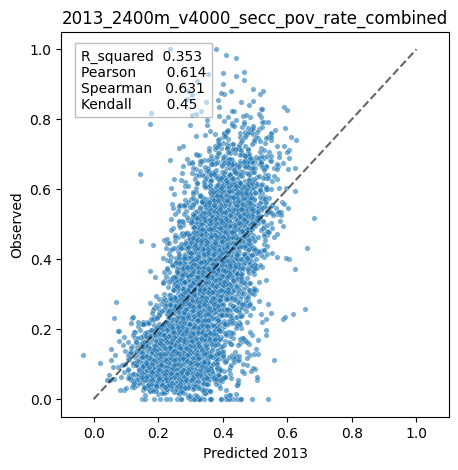

In [48]:
show_results(subdistrict_ys[y_name], subdistrict_ys["predicted"], file_name="scatter_subdistricts_"+experiment_name, title=experiment_name)

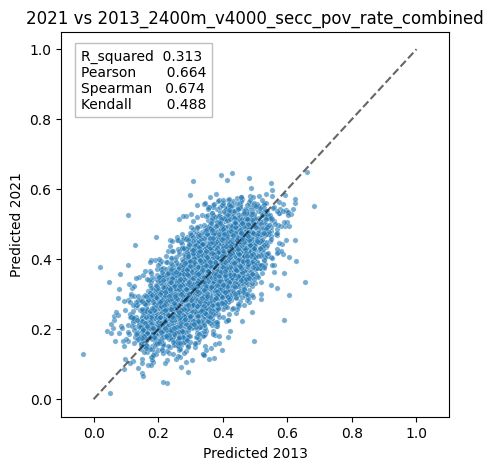

In [50]:
show_results(subdistrict_ys["predicted_21"], subdistrict_ys["predicted"], ylabel="Predicted 2021", file_name="2021_vs_13_scatter_subdistricts_"+experiment_name, title="2021 vs "+experiment_name)

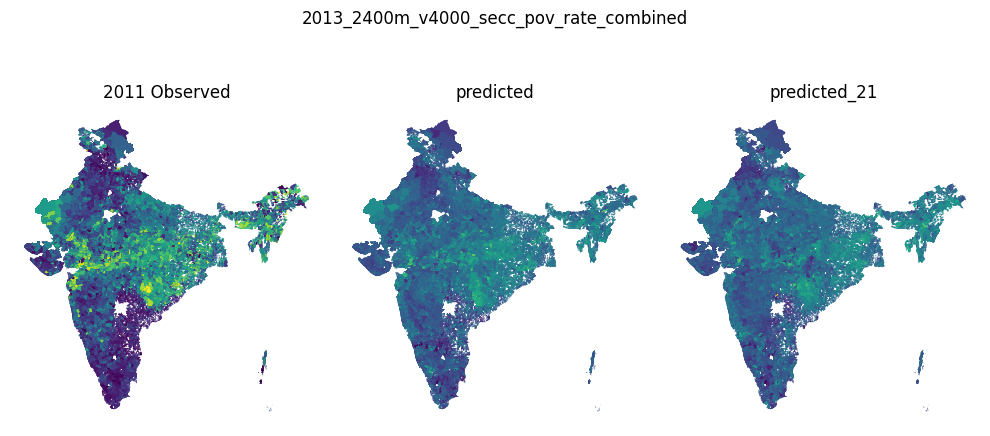

In [51]:
plot_prediction_maps(
    gdf=gdf_clean_test_y_subdistricts,
    y_name=y_name,
    y_pred_name="predicted",
    y_pred_2_name="predicted_21",
    vmin=0,
    vmax=1,
    file_name="2021_vs_13_maps_subdistricts_"+experiment_name,
    title=experiment_name,
    )

## Precision-Recall Curve


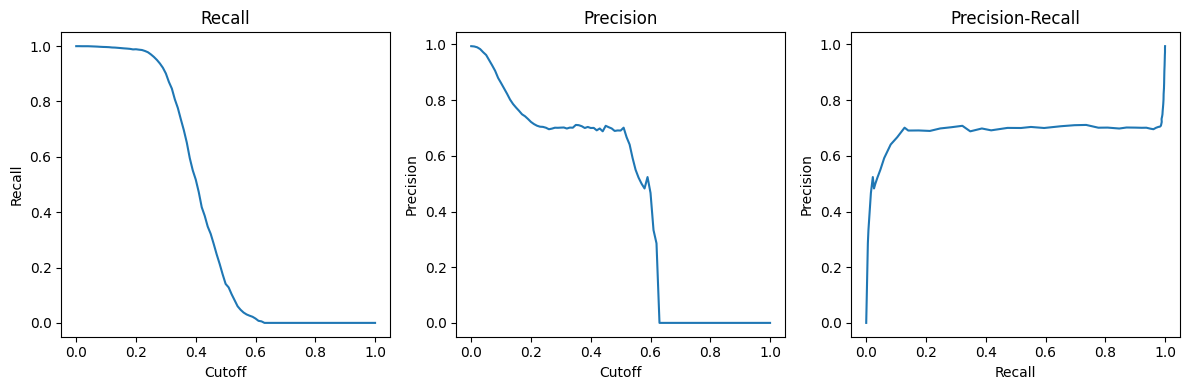

In [60]:
plot_precision_recall_curve(y_test=subdistrict_ys[y_name], y_pred=subdistrict_ys["predicted"], experiment_name=experiment_name)

## Top quintile predictions vs top quintile truth

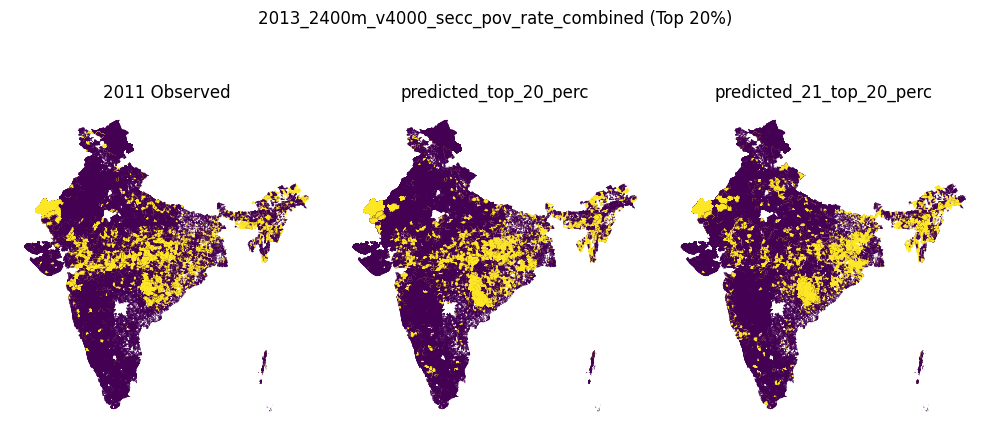

In [61]:
gdf_clean_test_y_subdistricts[y_name+"top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts[y_name], q=5, labels=False) == 4) * 1
gdf_clean_test_y_subdistricts["predicted_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted"], q=5, labels=False) == 4) * 1
gdf_clean_test_y_subdistricts["predicted_21_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted_21"], q=5, labels=False) == 4) * 1

plot_prediction_maps(
    gdf=gdf_clean_test_y_subdistricts,
    y_name=y_name+"top_20_perc",
    y_pred_name="predicted_top_20_perc",
    y_pred_2_name="predicted_21_top_20_perc",
    vmin=0,
    vmax=1,
    file_name="2021_vs_13_maps_sd_top20_"+experiment_name,
    title=experiment_name+" (Top 20%)",
    )

In [62]:
pred_top_quintile = np.percentile(y_pred, [80])[0]
y_pred_is_top_quintile = list(y_pred > pred_top_quintile)

pred_21_top_quintile = np.percentile(y_pred_21, [80])[0]
y_pred_21_is_top_quintile = list(y_pred_21 > pred_top_quintile)

test_top_quintile = np.percentile(y_test, [80])[0]
y_test_is_top_quintile = list(y_test > test_top_quintile)

In [63]:
precision = round(precision_score(y_test_is_top_quintile, y_pred_is_top_quintile), 3)
recall = round(recall_score(y_test_is_top_quintile, y_pred_is_top_quintile), 3)

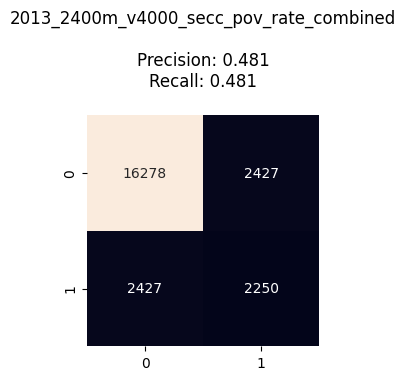

In [64]:
cm_array = confusion_matrix(y_test_is_top_quintile, y_pred_is_top_quintile)
df_cm = pd.DataFrame(cm_array, [0,1], [0,1])

plt.figure(figsize=(3,3))
sns.heatmap(df_cm, annot=True, fmt='.5g', cbar=False)
plt.title(f"{experiment_name}\n\nPrecision: {precision}\nRecall: {recall}\n")
plt.savefig(DATA_ROOT / "04_modeloutput" / ("confusion_matrix_"+experiment_name+".png"))